In [1]:
import re
import numpy as np
from wrapper_my_radex import myradex_wrapper as wrapper 
from scipy.constants import h,k,c
phy_c_cgs=299792458e2
phy_c_SI=299792458
phy_k_cgs=1.3806503e-16
phy_h_cgs=6.62606896e-27
phy_cm2erg=phy_h_cgs*phy_c_cgs
phy_cm2K=phy_cm2erg/phy_k_cgs
class colli_partner:
    def __init__(self,part_name):
        self.name=part_name
    def set_n_trans(self,n_trans):
        self.n_transitions=n_trans
    def set_n_T(self,n_T):
        self.n_T=n_T
    def set_colli_temp(self,col_temp):
        self.colli_temperature=col_temp
    def set_Cul(self,Cul):
        self.Cul=Cul
class mol_data:
    def __init__(self,mol_dir,mol_file):
        self.mol_dir=mol_dir
        self.mol_file=mol_file
        f=open(self.mol_dir+self.mol_file)
        file_list=re.split('\n',f.read())
        f.close()
        if_read=True
        self.mol_name=re.split(' ',file_list[1])
        self.n_level=int(file_list[5])
        self.level_energy=np.zeros(self.n_level)
        self.level_weight=np.zeros(self.n_level)
        nrow=7
        for i in range(self.n_level):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            self.level_energy[i]=float(line[1])*phy_cm2K
            self.level_weight[i]=float(line[2])
        nrow+=self.n_level+1
        self.n_transitions=int(file_list[nrow])
        nrow+=2
        self.rad_data=np.zeros([self.n_transitions,9]) # iup, ilow, Aul, freq, lambda, Eup, Elow, Bul, Blu
        for i in range(self.n_transitions):
            line=re.split(' |\t',file_list[nrow+i])
            line=[item for item in line if item!='']
            iu=int(line[1])
            il=int(line[2])
            self.rad_data[i,0]=iu
            self.rad_data[i,1]=il
            self.rad_data[i,2]=float(line[3])
            self.rad_data[i,3]=phy_c_cgs*(self.level_energy[iu-1]-self.level_energy[il-1])/phy_cm2K
            self.rad_data[i,4]=phy_c_SI/self.rad_data[i,3]*1e6  # micron
            self.rad_data[i,5]=self.level_energy[iu-1]
            self.rad_data[i,6]=self.level_energy[il-1]
            self.rad_data[i,7]=self.rad_data[i,2]/((2*phy_h_cgs/phy_c_cgs**2)*self.rad_data[i,3]**3)
            self.rad_data[i,8]=self.rad_data[i,7]*self.level_weight[iu-1]/self.level_weight[il-1]
        nrow+=self.n_transitions+1
        self.n_partner=int(file_list[nrow])
        nrow+=2
        self.colli_data={}
        for i in range(self.n_partner):
            line=re.split(' |-|\t|\+|:',file_list[nrow])
            line=[item for item in line if item!='']
            part_name=line[2]
            if part_name=='electron':
                part_name='e'
            elif part_name=='with':
                part_name=line[3]
            partner=colli_partner(part_name)
            partner.set_n_trans(int(file_list[nrow+2]))
            partner.set_n_T(int(file_list[nrow+4]))
            line=re.split(' |\t',file_list[nrow+6])
            line=np.array([item for item in line if item!=''])
            partner.set_colli_temp(line.astype(float))
            Cul=np.zeros([partner.n_transitions,partner.n_T+2])
            for j in range(partner.n_transitions):
                line=re.split(' |\t',file_list[nrow+8+j])
                line=np.array([item for item in line if item!=''])
                Cul[j]=line[1:].astype(float)
            partner.set_Cul(Cul.T)
            self.colli_data[part_name]=partner
            nrow+=9+partner.n_transitions
        self.data_shape=[self.n_level,self.n_transitions,self.n_partner]
        self.partner_names=list(self.colli_data.keys())
        self.colli_shape=[[self.colli_data[key].n_transitions,self.colli_data[key].n_T] for key in self.colli_data.keys()]
        self.level_data=np.concatenate([[self.level_energy],[self.level_weight]],axis=0).T
        colli_T=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])])
        colli_Cul=np.zeros([self.n_partner,max([self.colli_data[key].n_T for key in self.partner_names])+2,max([self.colli_data[key].n_transitions for key in self.partner_names])])
        for i in range(self.n_partner):
            partner_name=self.partner_names[i]
            colli_T[i,:self.colli_data[partner_name].n_T]=self.colli_data[partner_name].colli_temperature
            colli_Cul[i,:self.colli_data[partner_name].n_T+2,:self.colli_data[partner_name].n_transitions]=self.colli_data[partner_name].Cul
        self.colli_T=colli_T
        self.colli_Cul=colli_Cul
        space=' '
        self.part_name_str=space.join(self.partner_names)
def modified_blackbody(wl,T,A,b):
    #the input wavelength is in unit of um      
    wl_m=wl*1e-6
    v=c/wl_m
    return A*wl_m**(-b)*2*h*v**3/ c**2 / (np.exp(h*v / (k*T)) - 1)
def compute_Ncol(nH2,abundance_Kvir):    
    Ncol=3.08e18*nH2*abundance_Kvir*velocity_FWHM/1e5/(0.65*1.5**0.5*(nH2/1e3)**0.5)  #Papadopoulos et al. (2012)  Tunnard et al. (2015)
    return Ncol
def compute_Kvir(nH2,NH2col):
    Kvir=NH2col/(3.08e18*nH2*velocity_FWHM/1e5/(0.65*1.5**0.5*(nH2/1e3)**0.5))
    return Kvir
def Tbtoflux(Tb,freq,solid_angle):              #K, Hz, arcsec^2
    I_nu=2*phy_k_cgs*Tb*freq**2/(phy_c_cgs)**2          #Essensial Radio Astronomy P35
    flux=I_nu*solid_angle/(180/np.pi*3600)**2 *1e23 *velocity_FWHM/1e5               #Jykm/s  #Essensial Radio Astronomy P50
    return flux
def compute_gasmass(NH2col,solid_angle):
    area=solid_angle*ang_phy**2  #pc^2
    gasmass=NH2col*(2*1.66053904e-24)*area*3.08567758e18**2/1.98855e33 #solar mass
    return gasmass
def best_fitting(samples):
    nparm=samples.shape[-1]
    result=np.zeros([nparm,3])
    for i in range(nparm):
        mcmc=np.percentile(samples[:,i],[16,50,84])
        q=np.diff(mcmc)
        result[i]=[mcmc[1],-q[0],q[1]]
    return result
def dust_SED(wl_um,Tkin,mass):
    b=2
    dust_mass=mass/gas_dust
    A=dust_mass/((distance*3.0857*10**24)**2/3.98/(250*10**(-6))**b/1.9891e33*1e-26)
    fluxes=modified_blackbody(wl_um,Tkin,A,b)
    return fluxes
def run_myradex(Tkin,nH2,NXcol,Tbg,molecule,ini_occ=[]):
    if len(ini_occ)==0:
        ini_occ=molecule.level_weight*np.exp(-molecule.level_energy/Tkin)
        ini_occ=ini_occ/sum(ini_occ)
    params = {'tkin': Tkin,
              'ncol_x_cgs': NXcol,
              'h2_density_cgs': nH2,
              'tbg':Tbg,
              'mol_name':molecule.mol_name[0],
              'data_shape':molecule.data_shape,
              'n_transition':molecule.data_shape[1],
              'partner_names':molecule.part_name_str,
              'colli_shape':molecule.colli_shape,
              'level_data':molecule.level_data,
              'rad_data':molecule.rad_data,
              'colli_t':molecule.colli_T,
              'colli_data':molecule.colli_Cul,
              'ini_occ':ini_occ}      #initial occupation
    Tb,f_occupation=wrapper.run_one_params(**params)
    return Tb,f_occupation

In [2]:
source_name='NGC6240'
distance=103.1        #Mpc
ang_phy=np.pi/180/3600*distance*1e6    #pc/arcsec
Tbg=2.73                        #K
velocity_FWHM=360e5   #cm/s
gas_dust=100
co_Jup=np.arange(13)+1
co_flux=np.array([322,1492,3205,4634,5636,5913,6009,5833,4769,4162,3161,2592,2081])
co_err=np.array([29,253,642,371,149,82,60,89,82,67,74,60,60])
hcn_Jup=np.arange(4)+1
hcn_flux=np.array([14,61,74,41])
hcn_err=np.array([2,15,7,6])
hco_Jup=np.arange(4)+1
hco_flux=np.array([21,83,141,74])
hco_err=np.array([3,15,21,9])
dust_wl=np.array([70,100,160,250,350,500])
dust_flux=np.array([25,26.2,17.2,5.8,2,0.6])
dust_error=dust_flux*0.1
beam_size={'co':np.array([22,14,11,42.8,35.2,31.2,35.9,40.1,19.0,17.4,17.3,16.9,16.6]),
           'hcn':np.array([40,30,20,15]),
           'hco':np.array([40,30,20,15])}
co_mol=mol_data('/home/zj/Documents/radex_mol/','co.dat')
hcn_mol=mol_data('/home/zj/Documents/radex_mol/','hcn.dat')
hco_mol=mol_data('/home/zj/Documents/radex_mol/','hco+@xpol.dat')

In [3]:
class gas_compnent:
    def __init__(self,Tkin,nH2,Ncol,co_ab,hcn_ab,hco_ab,solidangle):
        self.Tkin,self.nH2,self.Ncol,self.co_ab,self.hcn_ab,self.hco_ab,self.solidangle=Tkin,nH2,Ncol,co_ab,hcn_ab,hco_ab,solidangle
        self.co_Ncol=Ncol*co_ab
        self.hcn_Ncol=Ncol*hcn_ab
        self.hco_Ncol=Ncol*hco_ab
        self.Kvir=compute_Kvir(self.nH2,self.Ncol)
    def compute_Tbs(self):
        self.co_Tb,self.co_occupation=run_myradex(self.Tkin,self.nH2,self.co_Ncol/(velocity_FWHM/1e5),Tbg,co_mol)
        self.hcn_Tb,self.hcn_occupation=run_myradex(self.Tkin,self.nH2,self.hcn_Ncol/(velocity_FWHM/1e5),Tbg,hcn_mol)
        self.hco_Tb,self.hco_occupation=run_myradex(self.Tkin,self.nH2,self.hco_Ncol/(velocity_FWHM/1e5),Tbg,hco_mol)
    def compute_flux(self):
        self.compute_Tbs()
        self.co_flux=Tbtoflux(self.co_Tb,co_mol.rad_data[:,3],self.solidangle)
        self.hcn_flux=Tbtoflux(self.hcn_Tb,hcn_mol.rad_data[:,3],self.solidangle)
        self.hco_flux=Tbtoflux(self.hco_Tb,hco_mol.rad_data[:,3],self.solidangle)
        return self.co_flux,self.hcn_flux,self.hco_flux
    def compute_mass(self):
        self.gasmass=compute_gasmass(self.Ncol,self.solidangle)
        return self.gasmass
    def compute_SED(self,wls):
        self.dustSED=dust_SED(wls,self.Tkin,self.compute_mass())
        return self.dustSED
def is_physical(params):
    lg_Tkin,lg_nH2,lg_Ncol,lg_ab_1,lg_ab_2,lg_filf=params
    Kvir=compute_Kvir(10**lg_nH2,10**lg_Ncol)
    if 1<lg_Tkin<3 and 3<lg_nH2<9 and -13<lg_ab_1<-4 and -13<lg_ab_2<-4 and -8<lg_filf+2*np.log10(beam_size['co'][0])<np.log10(4) and 0.5<Kvir<3:
        return True
    else:
        return False
def log_likelyhood(params):
    if not is_physical(params):
        return -np.inf
    Tkin,nH2,Ncol,hcn_ab,hco_ab,filf=10**params
    solidang=filf*1.133*beam_size['co'][0]**2
    gas_comp1=gas_compnent(Tkin,nH2,Ncol,1e-4,hcn_ab,hco_ab,solidang)
    model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
    dust_SED=gas_comp1.compute_SED(dust_wl)
    ll_dust=-0.5*np.sum(((dust_flux-dust_SED)/dust_error)**2)
    ll_hcn=-0.5*np.sum(((hcn_flux-model_hcn_flux_1[hcn_Jup-1])/hcn_err)**2)
    ll_hco=-0.5*np.sum(((hco_flux-model_hco_flux_1[hco_Jup-1])/hco_err)**2)
    ll_abs=-0.5*(np.sum((hcn_flux-model_hcn_flux_1[hcn_Jup-1])/hcn_err)+\
                 np.sum((hco_flux-model_hco_flux_1[hco_Jup-1])/hco_err))**2
    #print(ll_dust)
    return ll_hcn+ll_hco+ll_dust
#log_likelyhood(max_params)

In [4]:
param_g=[1.12642853,4.79146198,np.log10(compute_Ncol(10**4.79146198,1)),-7.9894926,-8.5091408,-2.3]
guess_range=np.array([0.5,1,1,1,1,1])/5
narrow_gauss=[0.01,0.01,0.01,0.01,0.01]
p0=param_g+guess_range* np.random.randn(20, 6)
nwalkers, ndim = p0.shape
print(p0.shape)
import emcee
from multiprocessing import Pool
import os
with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelyhood, args=(),pool=pool)
    state=sampler.run_mcmc(p0,4000,progress=True)


(20, 6)


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [03:01<00:00, 22.03it/s]


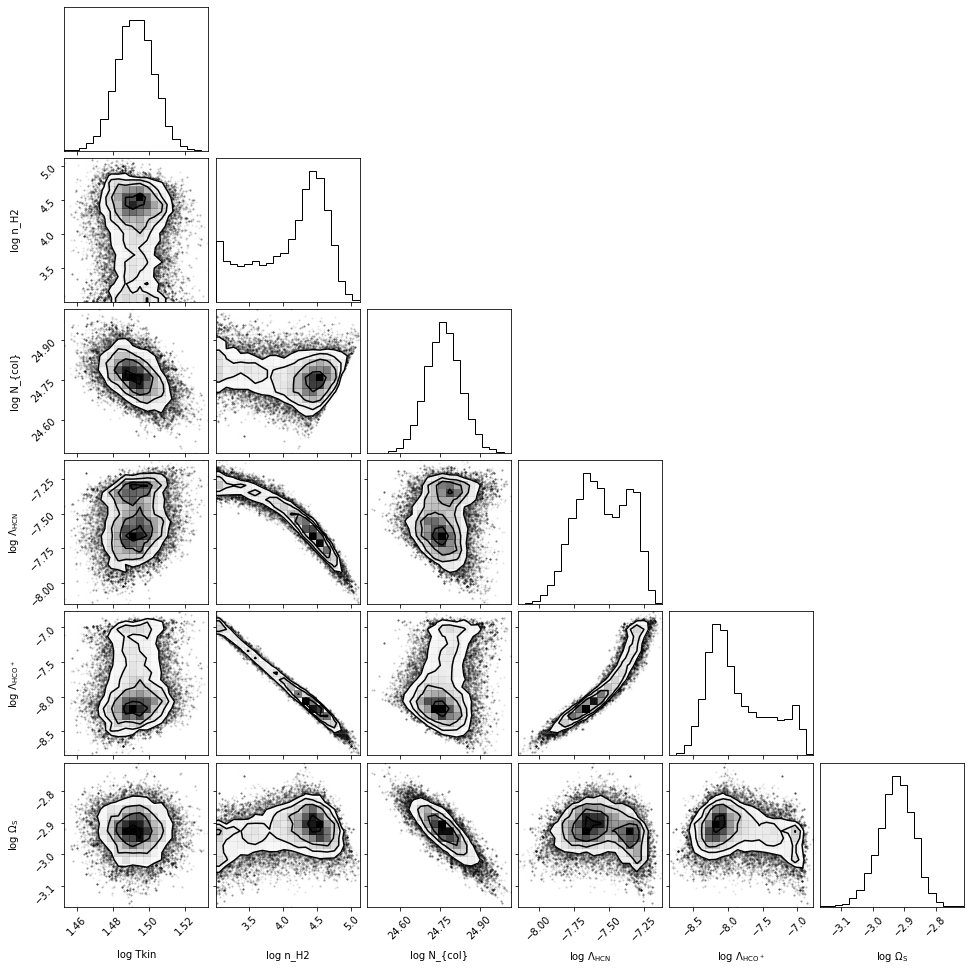

In [5]:
samples=sampler.get_chain(discard=1000)
log_prob_samples = sampler.get_log_prob(discard=1000)
max_index=np.where(log_prob_samples==np.max(log_prob_samples))
max_params=samples[max_index[0][0],max_index[1][0]]
sample_reshape=samples.reshape([samples.shape[0]*samples.shape[1],samples.shape[2]])
sample_flag=sample_reshape[sample_reshape[:,2]>22.6]
sample_flag=sample_reshape

import matplotlib.pyplot as plt
import corner

rng = [(x.min(),x.max()) for x in sample_flag.T]
fig=corner.corner(sample_flag, labels=[r"log Tkin",r"log n_H2",r"log N_{col}",r"log $\Lambda_{\rm HCN}$",
                                       r"log $\Lambda_{\rm HCO^+}$",r"log $\Omega_{\rm S}$"],range=rng,bins=20)
fig.savefig("corner_dense.png")

[[ 1.49231338e+00 -1.01131399e-02  1.02353320e-02]
 [ 4.26095488e+00 -8.25955930e-01  3.31910075e-01]
 [ 2.47639302e+01 -6.31207521e-02  6.48275487e-02]
 [-7.55845021e+00 -1.83931500e-01  2.24171387e-01]
 [-7.99114711e+00 -2.77132517e-01  6.88269639e-01]
 [-2.92417338e+00 -5.68069570e-02  5.31217173e-02]]
10.175271939981902
[28.99042134  5.57365834  2.01956536]


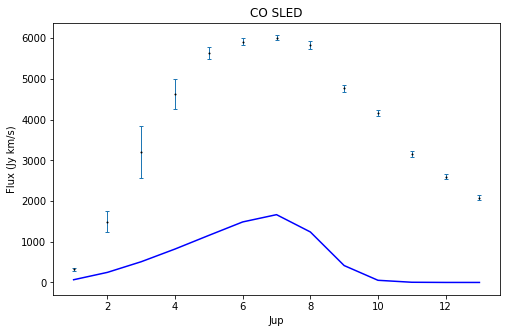

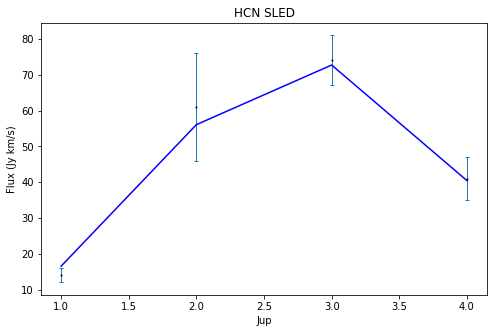

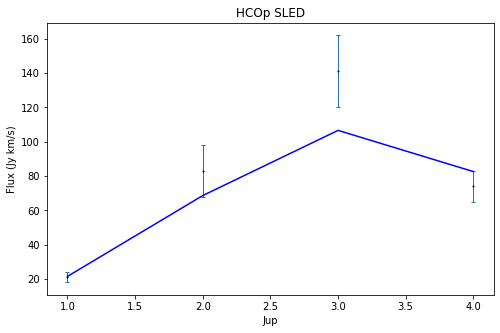

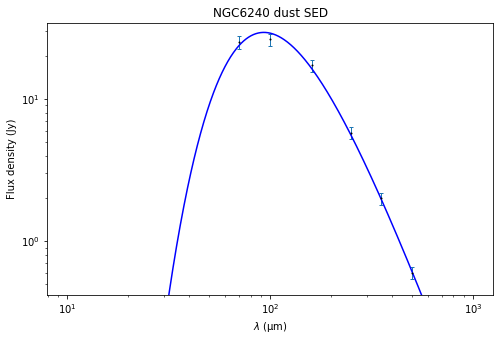

In [6]:
pdf_params=best_fitting(sample_flag)
print(pdf_params)

Tkin_1,nH2_1,Ncol_1,hcn_ab_Kvir_1,hco_ab_Kvir_1,filf_1=10**(max_params+np.array([0,0,0,0,0,0]))
solidang_1=filf_1*1.133*beam_size['co'][0]**2
gas_comp1=gas_compnent(Tkin_1,nH2_1,Ncol_1,1e-4,hcn_ab_Kvir_1,hco_ab_Kvir_1,solidang_1)
Kvir=compute_Kvir(10**sample_flag[:,1],10**sample_flag[:,2])
print(np.log10(gas_comp1.compute_mass()))
print(gas_comp1.compute_SED(np.array([100,250,350])))
model_co_flux_1,model_hcn_flux_1,model_hco_flux_1=gas_comp1.compute_flux()
import matplotlib.pyplot as plt
def draw_SLED(flux,error,model1,Jup,name):
    fig=plt.figure(figsize=[8,5])
    plt.errorbar(Jup,flux,yerr=error,fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
    J_new=np.linspace(1,5,1000)
    plt.plot(Jup,model1[Jup-1],color='b')
    #plt.plot(J_new,smooth)
    plt.title('%s SLED'%(name))
    plt.xlabel('Jup')
    #plt.yscale('log')
    plt.ylabel('Flux (Jy km/s)')
    plt.savefig(source_name+'_%s.pdf'%(name))
def draw_SED(dust_wl,dust_flux,dust_error):
    fig=plt.figure(figsize=[8,5])
    plt.errorbar(dust_wl,dust_flux,yerr=dust_error,fmt='o',elinewidth=1,ms=1,mfc="w",mec='k',capthick=1,capsize=2)
    wl_new=np.logspace(1,3,1000)
    plt.plot(wl_new,gas_comp1.compute_SED(wl_new),color='b')
    plt.title('%s dust SED'%(source_name))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([min(dust_flux-dust_error*3),max(dust_flux+dust_error*3)])
    plt.xlabel(r'$\lambda~\rm (\mu m)$')
    plt.ylabel('Flux density (Jy)')
    
draw_SLED(co_flux,co_err,model_co_flux_1,co_Jup,'CO')
draw_SLED(hcn_flux,hcn_err,model_hcn_flux_1,hcn_Jup,'HCN')
draw_SLED(hco_flux,hco_err,model_hco_flux_1,hco_Jup,'HCOp')
draw_SED(dust_wl,dust_flux,dust_error)

In [7]:
mcmc=np.percentile(Kvir,[16,50,84])
q=np.diff(mcmc)
mcmc
#min(Kvir)

array([0.64114726, 0.95089688, 2.67850647])

In [8]:
np.median(Kvir)
np.mean(Kvir)
np.std(Kvir)

1.1556973685151213

In [9]:
print('solid angle:',(10**(-2.63731463)*beam_size['co'][0]**2)**0.5,'arcsec^2')

solid angle: 1.0562467017404318 arcsec^2
